In [46]:
###################Setup instructions####################################
# root directory contains this file          
# root directory has the kaggle installation 
# training director is root/petfinder-pawpularity-score
# training image directory is root/petfinder-pawpularity-score/train
#########################################################################
import numpy as np
import pandas as pd
import os, sys
import cv2
import matplotlib.pyplot as plt
import sys
from PIL import Image, ImageOps,ExifTags
from PIL.ExifTags import TAGS
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

checking data
Root dir is /Users/vviswanathan/Documents/GitHub/w207-final-project
Width(min max): 90 1280
Height(min max): 113 1280
Train size RangeIndex(start=0, stop=9912, step=1)
checking data
Root dir is /Users/vviswanathan/Documents/GitHub/w207-final-project
Width(min max): 128 128
Height(min max): 128 128
Train size RangeIndex(start=0, stop=8, step=1)
loading data
Root dir is /Users/vviswanathan/Documents/GitHub/w207-final-project
Predicted: [('n02099712', 'Labrador_retriever', 0.46496004), ('n02085620', 'Chihuahua', 0.28033152), ('n02093256', 'Staffordshire_bullterrier', 0.041458353)]
Predicted: [('n02325366', 'wood_rabbit', 0.76418775), ('n02127052', 'lynx', 0.049571317), ('n02123045', 'tabby', 0.04197881)]
Predicted: [('n02093754', 'Border_terrier', 0.36171588), ('n02111129', 'Leonberg', 0.16136381), ('n02086079', 'Pekinese', 0.0727674)]
Predicted: [('n02093428', 'American_Staffordshire_terrier', 0.30950135), ('n02109961', 'Eskimo_dog', 0.17596383), ('n02093256', 'Staffordshir

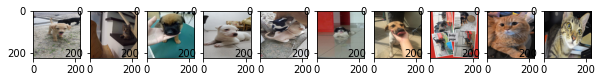

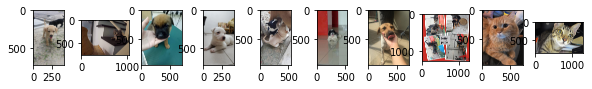

In [60]:
# read training file

# Check the image data
# All images load
# print min height and min width, max height and max width

def checkData(dtype="Train"):
    print('checking data')
    print('Root dir is', os.getcwd())
    dDir='petfinder-pawpularity-score/'
    dImgPath =  'petfinder-pawpularity-score/'+dtype+'/'
    dMdata=pd.read_csv('petfinder-pawpularity-score/'+ dtype+'.csv', engine = 'python')
    dMdata['path'] = os.getcwd()+'/petfinder-pawpularity-score/'+ dtype+'/'+dMdata['Id'] + '.jpg'

    minW=0
    maxW=0
    minH=0 
    maxH=0
    
    for ind in dMdata.index:
        imRgb = Image.open(dMdata['path'][ind])
        width, height = imRgb.size
        #if (width == 90):
        #    print(width, height)
        #if (height == 113):
        #    print(width, height)
        if ind == 0:
            minW=width
            maxW=width
            minH=height
            maxH=height
        else:
            if (width < minW):
                minW = width
            if (width > maxW):
                maxW = width
            if (height < minH):
                minH = height
            if (height > maxH):
                maxH = height
    print("Width(min max):", minW, maxW)
    print("Height(min max):", minH, maxH)
    print("Train size",  dMdata.index)
    
#
# convert the images into a normalized (100X100) default size
# accept parameters to load a specicified sample or all (in input is zero)
# in the final array normalize the values by diviing RGB values by 255 to get 
# to a 0-1 range
# 

def loadData(dtype='train',sampleSize=10, nHeight=100, nWidth=100):
    print('loading data')
    print('Root dir is', os.getcwd())
    dDir='petfinder-pawpularity-score/'
    dImgPath =  'petfinder-pawpularity-score/'+dtype+'/'
    dMdata=pd.read_csv('petfinder-pawpularity-score/'+ dtype+'.csv', engine = 'python')
    dMdata['path'] = os.getcwd()+'/petfinder-pawpularity-score/'+ dtype+'/'+dMdata['Id'] + '.jpg'

    model = ResNet50(weights='imagenet')
    #print(trainMdata.head())
    labels=[]
    imgArr=[]
    metadataArr=[]
    for ind in dMdata.index:
        metadata=[]
        if (sampleSize > 0):
            if ((ind+1)%11 == 0):
                break
        img = Image.open(dMdata['path'][ind])
        imRgb = img.convert("RGB")
        width, height = imRgb.size
        #print(width, height)
        imRgb = imRgb.resize((nHeight, nWidth))
        im = np.array(imRgb)
        imgArr.append(im)

        getAdditionalTags(model,im)
        
        if (dtype=='train'):
            labels.append(dMdata['Pawpularity'][ind])
        
        metadata.append(dMdata['Subject Focus'][ind])
        metadata.append(dMdata['Eyes'][ind])
        metadata.append(dMdata['Face'][ind])
        metadata.append(dMdata['Near'][ind])
        metadata.append(dMdata['Action'][ind])
        metadata.append(dMdata['Accessory'][ind])
        metadata.append(dMdata['Group'][ind])
        metadata.append(dMdata['Collage'][ind])
        metadata.append(dMdata['Human'][ind])
        metadata.append(dMdata['Occlusion'][ind])
        metadata.append(dMdata['Info'][ind])
        metadata.append(dMdata['Blur'][ind])
        metadataArr.append(metadata)
        
        augmentExif(img,dMdata)
        #print(labels)

    X_train=np.array(imgArr, dtype=float)
    X_train = X_train / 255.0
    if (dtype=='train'):
        return X_train, np.array(metadataArr, dtype=int), np.array(labels)
    else:
         return X_train, np.array(metadataArr, dtype=int)

def getAdditionalTags(model, imArr):
    im = np.expand_dims(imArr, axis=0)
    im = preprocess_input(im)
    preds = model.predict(im)
    print('Predicted:', decode_predictions(preds, top=3)[0])
        
def augmentExif(img,df):
    exifData = img._getexif()
    if exifData is None:
        return
    else:
        print (type(exifData))
        for tagId in exifData:
            # get the tag name, instead of human unreadable tag id
            tag = TAGS.get(tagId, tagId)
            data = exifdata.get(tagId)
            # decode bytes 
            if isinstance(data, bytes):
                data = data.decode()
                print(f"{tag:25}: {data}")

def printNormalizedTrainImages(sampleSize=10):
    plt.figure(figsize =(10, 1))
    for i in range(sampleSize):
        plt.subplot(1, 10, i+1)
        plt.imshow(T_images[i])
        
def printActualTrainImages(sampleSize=10):
    dtype='train'
    dDir='petfinder-pawpularity-score/'
    dImgPath =  'petfinder-pawpularity-score/'+dtype+'/'
    dMdata=pd.read_csv('petfinder-pawpularity-score/'+ dtype+'.csv', engine = 'python')
    dMdata['path'] = os.getcwd()+'/petfinder-pawpularity-score/'+ dtype+'/'+dMdata['Id'] + '.jpg'

    plt.figure(figsize =(10, 1))
    for i in range(sampleSize):
        plt.subplot(1, 10, i+1)
        plt.imshow(Image.open(dMdata['path'][i]))


checkData(dtype="train")
checkData(dtype="test")
T_images, T_metadata, T_labels = loadData(dtype="train",sampleSize=10, nHeight=224, nWidth=224) # load all
D_images, D_metadata = loadData(dtype="test",sampleSize=10, nHeight=224, nWidth=224) # load all
print('X_data     shape:', T_images.shape)
print('X_labels   shape:', T_labels.shape)
print('X_metadata shape:', T_metadata.shape)
print('Y_data     shape:', D_images.shape)
print('Y_metadata shape:', D_metadata.shape)
printNormalizedTrainImages(sampleSize=10)
printActualTrainImages(sampleSize=10)